requirements:
numpy opencv-python matplotlib scikit-image scikit-learn xgboost tensorflow tqdm seaborn notebook

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from skimage import exposure
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models




In [2]:
DATASET_PATH = "../vehicle-type-detection/r7bthvstxw-1"

# Resize settings
IMG_SIZE = (128, 64)  # (height, width)

# Storage
X = []
y = []

# Detect class folders
class_names = sorted([
    folder for folder in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, folder))
])

print("Classes found:", class_names)

# Load images
for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)

    for filename in tqdm(os.listdir(class_dir), desc=f"Loading {class_name}"):
        file_path = os.path.join(class_dir, filename)

        img = cv2.imread(file_path)
        if img is None:
            continue  # skip corrupted or unreadable files

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, (IMG_SIZE[1], IMG_SIZE[0]))

        X.append(img_resized)
        y.append(class_name)

# Convert to numpy arrays
X = np.array(X, dtype="float32")
y = np.array(y)

# Normalize pixel values
X = X / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Dataset loaded!")
print("X shape:", X.shape)
print("y shape:", y_encoded.shape)
print("Encoded classes:", label_encoder.classes_)

Classes found: ['hatchback', 'motorcycle', 'pickup', 'sedan', 'suv']


Loading suv: 100%|██████████| 129/129 [00:00<00:00, 1141.58it/s]

Dataset loaded!
X shape: (1310, 128, 64)
y shape: (1310,)
Encoded classes: ['hatchback' 'motorcycle' 'pickup' 'sedan' 'suv']


In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# Pick one example image file
example_class = class_names[0]
example_path = os.path.join(DATASET_PATH, example_class, os.listdir(os.path.join(DATASET_PATH, example_class))[0])

print("Using example image:", example_path)


Using example image: ../vehicle-type-detection/r7bthvstxw-1\hatchback\PIC_0.jpg


In [4]:
# Load original (BGR)
img_bgr = cv2.imread(example_path)

# Convert to grayscale
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Resize
img_resized = cv2.resize(img_gray, (IMG_SIZE[1], IMG_SIZE[0]))

# Normalize
img_normalized = img_resized / 255.0


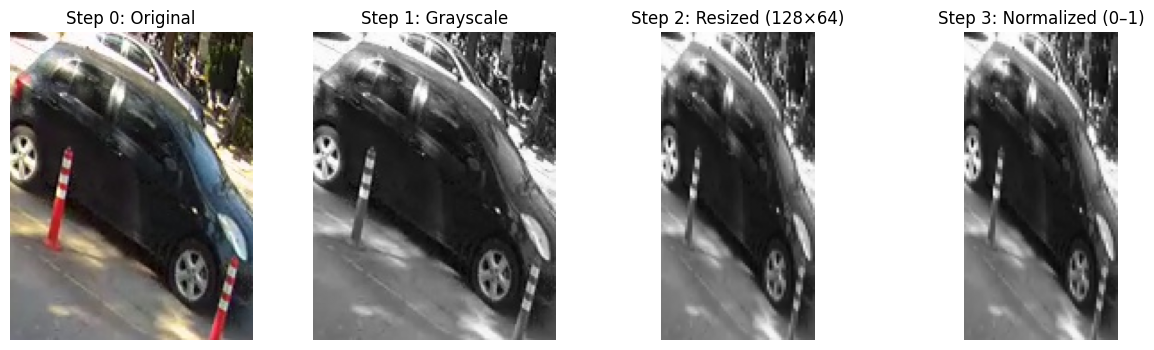

In [5]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title("Step 0: Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(img_gray, cmap="gray")
plt.title("Step 1: Grayscale")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(img_resized, cmap="gray")
plt.title("Step 2: Resized (128×64)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(img_normalized, cmap="gray")
plt.title("Step 3: Normalized (0–1)")
plt.axis("off")

plt.show()


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)

(917, 128, 64) (196, 128, 64) (197, 128, 64)


Image shape: (128, 64)


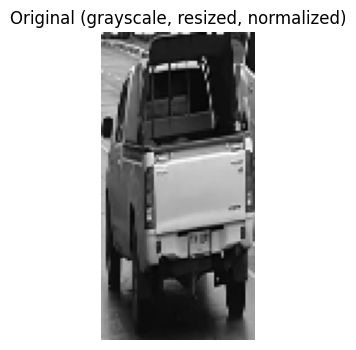

In [7]:
# Pick the first training image
img_example = X_train[2]   # shape: (128, 64)
print("Image shape:", img_example.shape)

plt.figure(figsize=(4, 4))
plt.imshow(img_example, cmap="gray")
plt.title("Original (grayscale, resized, normalized)")
plt.axis("off")
plt.show()

In [8]:
# Compute HOG features + visualization for the first image
fd, hog_image = hog(
    img_example,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    visualize=True
)

print("HOG feature length:", fd.shape)


HOG feature length: (3780,)


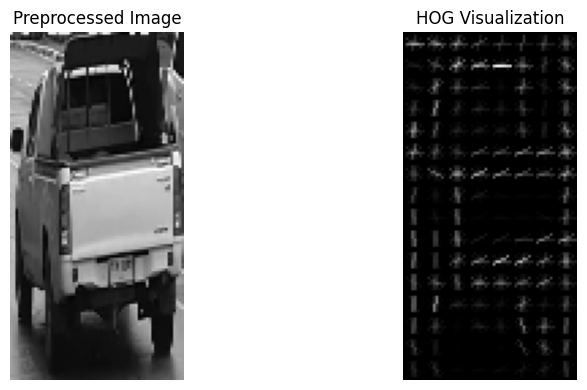

In [9]:
# Improve contrast of HOG image for visualization
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, hog_image.max()))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_example, cmap="gray")
plt.title("Preprocessed Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap="gray")
plt.title("HOG Visualization")
plt.axis("off")

plt.tight_layout()
plt.show()


In [10]:
def extract_hog_batch(X, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm="L2-Hys"):
    """
    X: numpy array of shape (N, H, W) with grayscale images.
    Returns: numpy array of shape (N, D) with HOG feature vectors.
    """
    features = []
    for img in tqdm(X, desc="Extracting HOG"):
        feat = hog(
            img,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm
        )
        features.append(feat)
    return np.array(features, dtype="float32")


In [11]:
X_train_hog = extract_hog_batch(X_train)
X_val_hog   = extract_hog_batch(X_val)
X_test_hog  = extract_hog_batch(X_test)

print("HOG train shape:", X_train_hog.shape)
print("HOG val shape:  ", X_val_hog.shape)
print("HOG test shape: ", X_test_hog.shape)


Extracting HOG: 100%|██████████| 197/197 [00:00<00:00, 346.84it/s]

HOG train shape: (917, 3780)
HOG val shape:   (196, 3780)
HOG test shape:  (197, 3780)


In [12]:
# 1) Scale HOG features
scaler = StandardScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_val_hog_scaled   = scaler.transform(X_val_hog)
X_test_hog_scaled  = scaler.transform(X_test_hog)

# 2) PCA for feature selection (keep 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_hog_scaled)
X_val_pca   = pca.transform(X_val_hog_scaled)
X_test_pca  = pca.transform(X_test_hog_scaled)

print("PCA train shape:", X_train_pca.shape)
print("PCA val shape:  ", X_val_pca.shape)
print("PCA test shape: ", X_test_pca.shape)
print("Number of components:", pca.n_components_)


PCA train shape: (917, 527)
PCA val shape:   (196, 527)
PCA test shape:  (197, 527)
Number of components: 527


Number of components for 95% variance: 527
Cumulative variance at that point: 0.950013


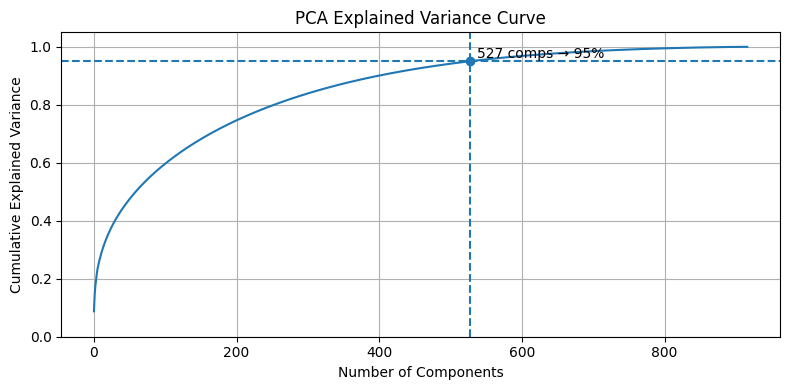

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA on the scaled training data (if not already done)
pca_full = PCA().fit(X_train_hog_scaled)

# Cumulative explained variance
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Index of first component where cumulative variance >= 0.95
n_components_95 = np.argmax(cum_var >= 0.95) + 1  # +1 because indices start at 0
print("Number of components for 95% variance:", n_components_95)
print("Cumulative variance at that point:", cum_var[n_components_95 - 1])

# Plot
plt.figure(figsize=(8, 4))
plt.plot(cum_var)
plt.axhline(0.95, linestyle="--")              # horizontal line at 95%
plt.axvline(n_components_95, linestyle="--")   # vertical line at chosen component
plt.scatter([n_components_95], [cum_var[n_components_95 - 1]])  # highlight point

plt.title("PCA Explained Variance Curve")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

# Optional annotation
plt.text(
    n_components_95 + 10,
    0.95,
    f"{n_components_95} comps → 95%",
    va="bottom"
)

plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
log_reg = LogisticRegression(
    max_iter=500,
    multi_class="multinomial",
    solver="lbfgs"
)
log_reg.fit(X_train_pca, y_train)

y_val_pred_lr = log_reg.predict(X_val_pca)
print("Validation accuracy (LogReg):", accuracy_score(y_val, y_val_pred_lr))
print(classification_report(y_val, y_val_pred_lr, target_names=label_encoder.classes_))

c:\Users\henri\anaconda3\envs\datadrevet4\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy (LogReg): 0.8928571428571429
              precision    recall  f1-score   support

   hatchback       0.88      0.81      0.85        27
  motorcycle       1.00      0.95      0.97        19
      pickup       0.90      0.97      0.93        71
       sedan       0.88      0.95      0.91        60
         suv       0.82      0.47      0.60        19

    accuracy                           0.89       196
   macro avg       0.89      0.83      0.85       196
weighted avg       0.89      0.89      0.89       196



In [15]:
y_test_pred_lr = log_reg.predict(X_test_pca)
print("Test accuracy (LogReg):", accuracy_score(y_test, y_test_pred_lr))
print(classification_report(y_test, y_test_pred_lr, target_names=label_encoder.classes_))

Test accuracy (LogReg): 0.883248730964467
              precision    recall  f1-score   support

   hatchback       0.83      0.74      0.78        27
  motorcycle       1.00      0.94      0.97        18
      pickup       0.88      0.94      0.91        72
       sedan       0.88      0.95      0.91        60
         suv       0.86      0.60      0.71        20

    accuracy                           0.88       197
   macro avg       0.89      0.84      0.86       197
weighted avg       0.88      0.88      0.88       197



In [16]:
start_time = time.time()

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    eval_metric="mlogloss"
)

xgb.fit(X_train_pca, y_train)
training_time_xgb = time.time() - start_time

print(f"Training time (XGBoost): {training_time_xgb:.2f} seconds")

y_val_pred_xgb = xgb.predict(X_val_pca)

print("Validation accuracy (XGBoost):", accuracy_score(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb, target_names=label_encoder.classes_))

Training time (XGBoost): 32.22 seconds
Validation accuracy (XGBoost): 0.8214285714285714
              precision    recall  f1-score   support

   hatchback       0.75      0.67      0.71        27
  motorcycle       1.00      0.95      0.97        19
      pickup       0.81      0.96      0.88        71
       sedan       0.82      0.88      0.85        60
         suv       0.80      0.21      0.33        19

    accuracy                           0.82       196
   macro avg       0.83      0.73      0.75       196
weighted avg       0.82      0.82      0.80       196



In [17]:
y_test_pred_xgb = xgb.predict(X_test_pca)
print("Test accuracy (XGBoost):", accuracy_score(y_test, y_test_pred_xgb))
print(classification_report(y_test, y_test_pred_xgb, target_names=label_encoder.classes_))

Test accuracy (XGBoost): 0.8527918781725888
              precision    recall  f1-score   support

   hatchback       0.90      0.70      0.79        27
  motorcycle       1.00      0.94      0.97        18
      pickup       0.81      0.97      0.89        72
       sedan       0.83      0.92      0.87        60
         suv       1.00      0.35      0.52        20

    accuracy                           0.85       197
   macro avg       0.91      0.78      0.81       197
weighted avg       0.87      0.85      0.84       197



In [18]:
# Add channel dimension: (N, 128, 64) -> (N, 128, 64, 1)
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn   = X_val[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]

num_classes = len(label_encoder.classes_)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("Train images:", X_train_cnn.shape, "Train labels (one-hot):", y_train_cat.shape)
print("Val images:   ", X_val_cnn.shape,   "Val labels (one-hot):  ", y_val_cat.shape)
print("Test images:  ", X_test_cnn.shape,  "Test labels (one-hot): ", y_test_cat.shape)


Train images: (917, 128, 64, 1) Train labels (one-hot): (917, 5)
Val images:    (196, 128, 64, 1) Val labels (one-hot):   (196, 5)
Test images:   (197, 128, 64, 1) Test labels (one-hot):  (197, 5)


In [19]:
# Data augmentation for training (slightly milder)
train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

# No augmentation for validation/test
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train_cnn, y_train_cat,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val_cnn, y_val_cat,
    batch_size=32,
    shuffle=False
)


In [20]:
# Compute class weights to help minority classes (e.g. suv, hatchback)
classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = {int(cls): float(w) for cls, w in zip(classes, class_weights_array)}
print("Class weights:", class_weights)


Class weights: {0: 1.4440944881889763, 1: 2.1576470588235295, 2: 0.5474626865671641, 3: 0.655, 4: 2.037777777777778}


In [21]:
def build_cnn(filters1=32, filters2=64, dense_units=128, dropout_rate=0.3):
    model = models.Sequential([
        # Conv block 1
        layers.Conv2D(filters1, (3, 3), activation='relu', padding='same', input_shape=(128, 64, 1)),
        layers.MaxPooling2D((2, 2)),
        
        # Conv block 2
        layers.Conv2D(filters2, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Quick sanity check
model_tmp = build_cnn()
model_tmp.summary()


c:\Users\henri\anaconda3\envs\datadrevet4\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,893 (16.07 MB)

 Trainable params: 4,213,893 (16.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
configs = [
    # Small models
    dict(filters1=8,  filters2=16,  dense_units=32,  dropout_rate=0.3),
    dict(filters1=16, filters2=32,  dense_units=64,  dropout_rate=0.3),

    # Medium models
    dict(filters1=32, filters2=64,  dense_units=128, dropout_rate=0.3),
    dict(filters1=32, filters2=64,  dense_units=128, dropout_rate=0.1),
    dict(filters1=32, filters2=64,  dense_units=256, dropout_rate=0.3),

    # Large models
    dict(filters1=64, filters2=128, dense_units=256, dropout_rate=0.3),
]


best_run = None
best_model = None

for cfg in configs:
    print("\n=== Training config:", cfg, "===")
    model = build_cnn(**cfg)
    
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=val_generator,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=1
    )
    training_time = time.time() - start_time
    
    best_val_acc = max(history.history["val_accuracy"])
    
    run_info = {
        "config": cfg,
        "best_val_acc": best_val_acc,
        "training_time_sec": training_time,
        "history": history.history
    }
    
    print(f"Best val acc: {best_val_acc:.4f}, training time: {training_time:.1f} s")
    
    if best_run is None or best_val_acc > best_run["best_val_acc"]:
        best_run = run_info
        best_model = model  # keep the model with best validation acc

print("\n=== Best config found ===")
print("Config:", best_run["config"])
print("Best val accuracy:", best_run["best_val_acc"])
print("Training time (s):", best_run["training_time_sec"])



=== Training config: {'filters1': 8, 'filters2': 16, 'dense_units': 32, 'dropout_rate': 0.3} ===
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1897 - loss: 1.6141 - val_accuracy: 0.1990 - val_loss: 1.5481
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2192 - loss: 1.4745 - val_accuracy: 0.1888 - val_loss: 1.4596
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3119 - loss: 1.3754 - val_accuracy: 0.4031 - val_loss: 1.2952
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3664 - loss: 1.2921 - val_accuracy: 0.5153 - val_loss: 1.2172
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4002 - loss: 1.2782 - val_accuracy: 0.6735 - val_loss: 1.0255
Best val acc: 0.6735, training time: 6.4 s

=== Training config: {'filters1': 16, 'filters2': 32, 'dense_units': 64, 'dropout_rate': 0.3} ===
Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2105 - loss: 1.6255 - val_accuracy: 0.1582 - val_loss: 1.536

In [24]:
# Predict on test set
y_test_pred_probs = best_model.predict(X_test_cnn)
y_test_pred_cnn = y_test_pred_probs.argmax(axis=1)

test_acc_cnn = accuracy_score(y_test, y_test_pred_cnn)
print("Test accuracy (CNN):", test_acc_cnn)
print(classification_report(y_test, y_test_pred_cnn, target_names=label_encoder.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Test accuracy (CNN): 0.8578680203045685
              precision    recall  f1-score   support

   hatchback       0.70      0.78      0.74        27
  motorcycle       1.00      0.94      0.97        18
      pickup       0.88      0.94      0.91        72
       sedan       0.94      0.80      0.86        60
         suv       0.68      0.75      0.71        20

    accuracy                           0.86       197
   macro avg       0.84      0.84      0.84       197
weighted avg       0.87      0.86      0.86       197

